In [1]:
from csv import DictReader

with open('_data/properties_master.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

PROPERTIES = [
    'properties.autoignition_temp.value'
]

samples = []
for row in rows:
    _n_present = 0
    for prop in PROPERTIES:
        if row[prop] != '-':

            # Special case for CLEAR outlier
            if prop == 'properties.autoignition_temp.value':
                if float(row[prop]) > 800:
                    break

            _n_present += 1
            continue
        else:
            break
    if _n_present >= len(PROPERTIES):
        samples.append(row)

target_vals = []
for s in samples:
    target_vals.append([float(s[p]) for p in PROPERTIES])
smiles = [s['canonical_smiles'] for s in samples]

print(len(smiles))
print(len(target_vals), len(target_vals[0]))

78
78 1


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from ecnet.datasets import QSPRDataset
import torch

smi_train, smi_test, tar_train, tar_test = train_test_split(smiles, target_vals, test_size=0.15, random_state=42)

ds_train = QSPRDataset(smi_train, tar_train, backend='alvadesc')
ds_test = QSPRDataset(smi_test, tar_test, backend='alvadesc')

print('I/O shapes prior to PC calculation:')
print(ds_train.desc_vals.shape, ds_train.target_vals.shape)
print(ds_test.desc_vals.shape, ds_test.target_vals.shape, '\n')

pca = PCA(n_components=ds_train.desc_vals.shape[0], svd_solver='full', random_state=0)
pca.fit(ds_train.desc_vals)

ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals)).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals)).type(torch.float32)

print('I/O shapes after PC calculation:')
print(ds_train.desc_vals.shape, ds_train.target_vals.shape)
print(ds_test.desc_vals.shape, ds_test.target_vals.shape)

I/O shapes prior to PC calculation:
torch.Size([66, 5305]) torch.Size([66, 1])
torch.Size([12, 5305]) torch.Size([12, 1]) 

I/O shapes after PC calculation:
torch.Size([66, 66]) torch.Size([66, 1])
torch.Size([12, 66]) torch.Size([12, 1])


In [3]:
from ecnet import ECNet

model = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 1)
train_loss, _ = model.fit(dataset=ds_train, valid_size=0.15, shuffle=True, patience=32, batch_size=1, epochs=500, verbose=10, lr=0.001)

Epoch: 0 | Train loss: 111549.48647335172 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 2215.451974760159 | Valid loss: 598.5186767578125
Epoch: 20 | Train loss: 289.37405152253007 | Valid loss: 111.00809478759766
Epoch: 30 | Train loss: 71.42772832765642 | Valid loss: 103.63423919677734
Epoch: 40 | Train loss: 745.6080746091902 | Valid loss: 230.5049591064453
Epoch: 50 | Train loss: 1175.3311664547239 | Valid loss: 383.5366516113281
Epoch: 60 | Train loss: 601.147713875265 | Valid loss: 218.95333862304688
Epoch: 70 | Train loss: 246.94311381024974 | Valid loss: 111.58143615722656


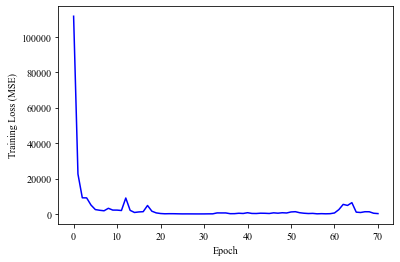

In [4]:
from matplotlib import pyplot as plt

epoch = [i for i in range(len(train_loss))]

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(epoch, train_loss, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.show()

In [5]:
from sklearn.metrics import r2_score, median_absolute_error

pred_train = model(ds_train.desc_vals).detach().numpy()
pred_test = model(ds_test.desc_vals).detach().numpy()

pred_ai_train = [p[0] for p in pred_train]
pred_ai_test = [p[0] for p in pred_test]

tar_ai_train = [t[0] for t in tar_train]
tar_ai_test = [t[0] for t in tar_test]

print('Autoignition Temperature:')
print('Train: {:.3f} | {:.3f}'.format(
    median_absolute_error(tar_ai_train, pred_ai_train),
    r2_score(tar_ai_train, pred_ai_train)
))
print('Test: {:.3f} | {:.3f}'.format(
    median_absolute_error(tar_ai_test, pred_ai_test),
    r2_score(tar_ai_test, pred_ai_test)
))

Autoignition Temperature:
Train: 8.379 | 0.971
Test: 26.735 | 0.740


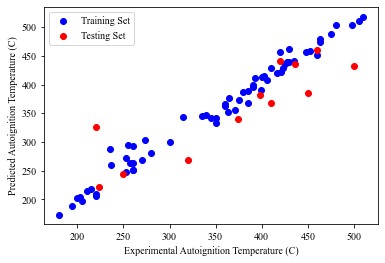

In [6]:
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental Autoignition Temperature (C)')
plt.ylabel('Predicted Autoignition Temperature (C)')
plt.scatter(tar_ai_train, pred_ai_train, color='blue', label='Training Set')
plt.scatter(tar_ai_test, pred_ai_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()